In [46]:
import pandas as pd
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [23]:
# Load and prepare data
series_name = "ETH-USD"
data = pd.read_csv(f"./data/{series_name}.csv", index_col="Date", parse_dates=True)
data["Close"] = pd.to_numeric(data["Close"].replace(",","", regex=True))

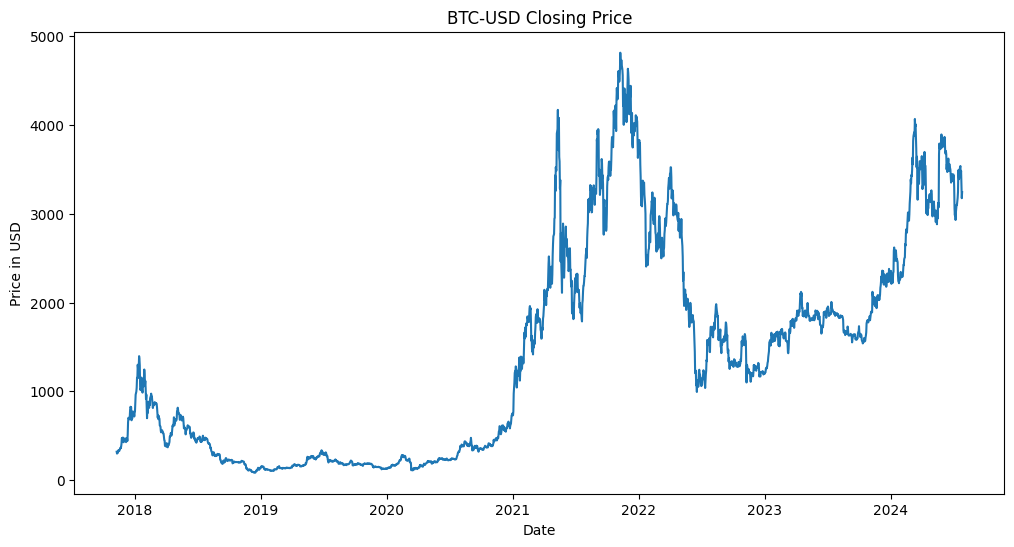

In [24]:
# Plot original data
plt.figure(figsize=(12,6))
plt.plot(data["Close"])
plt.title(f"{series_name} Closing Price")
plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.show()

In [25]:
# Difference the data
diff_data = data["Close"].diff().dropna()

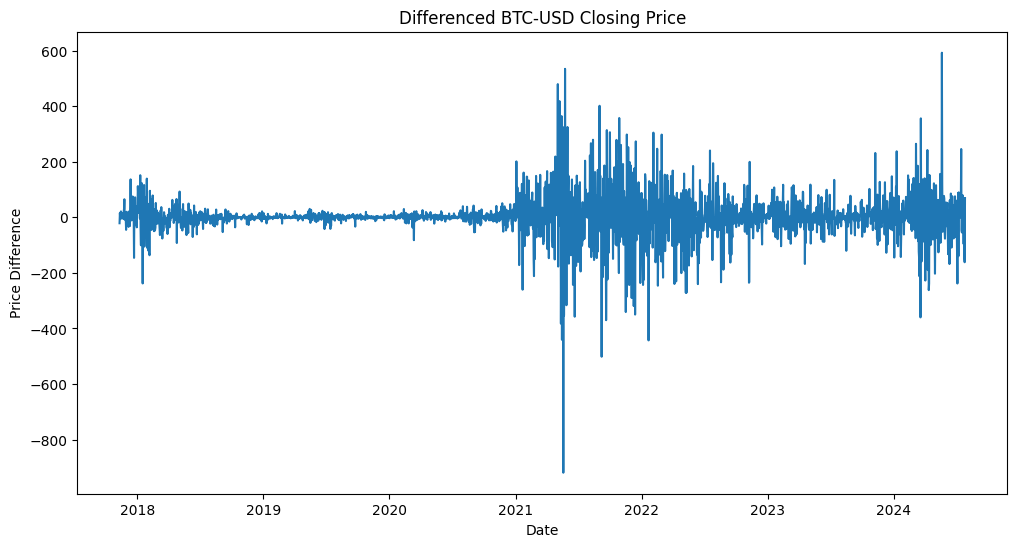

In [26]:
# Plot differenced data
plt.figure(figsize=(12,6))
plt.plot(diff_data)
plt.title("Differenced {series_name} Closing Price")
plt.xlabel("Date")
plt.ylabel("Price Difference")
plt.show()

In [27]:
# Split data into train and test sets
train_data, test_data = diff_data[:int(len(diff_data)*0.9)], diff_data[int(len(diff_data)*0.9):]

In [28]:
# Auto ARIMA to find the best parameters
model_autoARIMA = auto_arima(train_data, start_p=1, start_q=1,
                             test='adf',
                             max_p=5, max_q=5,
                             m=7,  # Weekly seasonality
                             d=None,
                             seasonal=True,
                             start_P=0, 
                             D=1, 
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=5.96 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=26777.791, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=26180.896, Time=1.55 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=2.33 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=26775.791, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=26760.661, Time=0.52 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=25848.526, Time=5.25 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=4.08 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=25859.717, Time=2.33 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=25848.174, Time=3.24 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=26177.490, Time=1.43 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=4.92 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=1.95 sec
 ARIMA(3,0,0)(2,1,0)[7] intercept   : AIC=25848.323, Ti

In [29]:
print(model_autoARIMA.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 2205
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 7)   Log Likelihood              -12917.691
Date:                            Mon, 05 Aug 2024   AIC                          25845.381
Time:                                    11:25:11   BIC                          25873.858
Sample:                                11-10-2017   HQIC                         25855.787
                                     - 11-23-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7624      0.054    -14.113      0.000      -0.868      -0.657
ma.L1          0.7064      0.060   

In [30]:
# Get the order and seasonal order from the auto_arima model
order = model_autoARIMA.order
seasonal_order = model_autoARIMA.seasonal_order
print(f"Best SARIMAX order: {order}")
print(f"Best SARIMAX seasonal order: {seasonal_order}")

Best SARIMAX order: (1, 0, 1)
Best SARIMAX seasonal order: (2, 1, 0, 7)


In [31]:
# Build SARIMAX model with the best order
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
results = model.fit()
print(results.summary())

c:\Users\HomePC\Documents\finance_ml\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HomePC\Documents\finance_ml\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 2205
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 7)   Log Likelihood              -12917.691
Date:                            Mon, 05 Aug 2024   AIC                          25845.381
Time:                                    11:25:14   BIC                          25873.858
Sample:                                11-10-2017   HQIC                         25855.787
                                     - 11-23-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7624      0.054    -14.113      0.000      -0.868      -0.657
ma.L1          0.7064      0.060   

In [32]:
# Forecast
fc = results.get_forecast(steps=len(test_data))
fc_mean = fc.predicted_mean

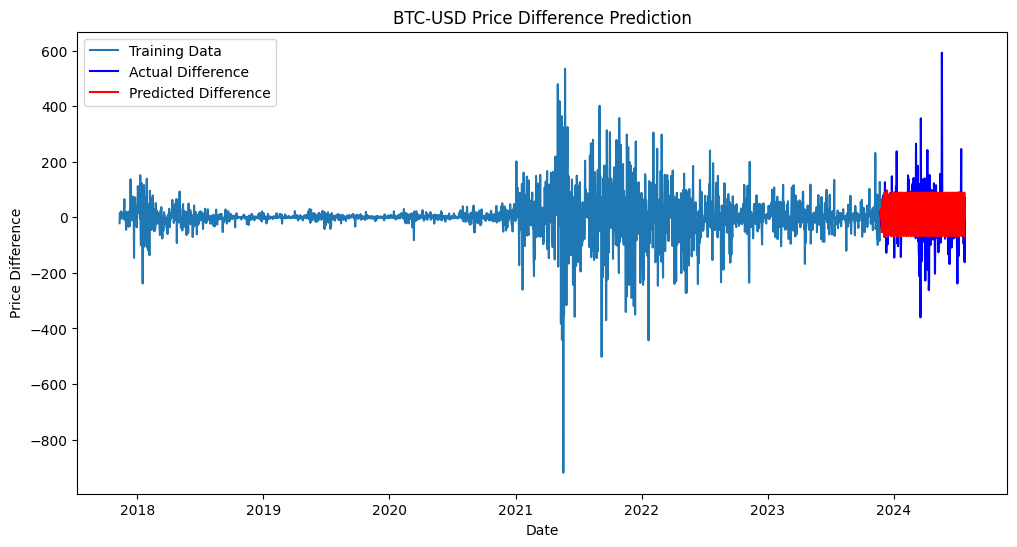

In [33]:
# Plot the forecast (differenced data)
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, color='blue', label='Actual Difference')
plt.plot(test_data.index, fc_mean, color='red', label='Predicted Difference')
plt.title('{series_name} Price Difference Prediction')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend(loc='upper left')
plt.show()

In [34]:
# Cumulative sum to get back to original scale
fc_cumsum = fc_mean.cumsum()
actual_cumsum = test_data.cumsum()

In [35]:
# Add the last training data point to get back to the original scale
last_train_value = data['Close'].iloc[len(train_data)]
fc_forecast = last_train_value + fc_cumsum
actual_forecast = last_train_value + actual_cumsum

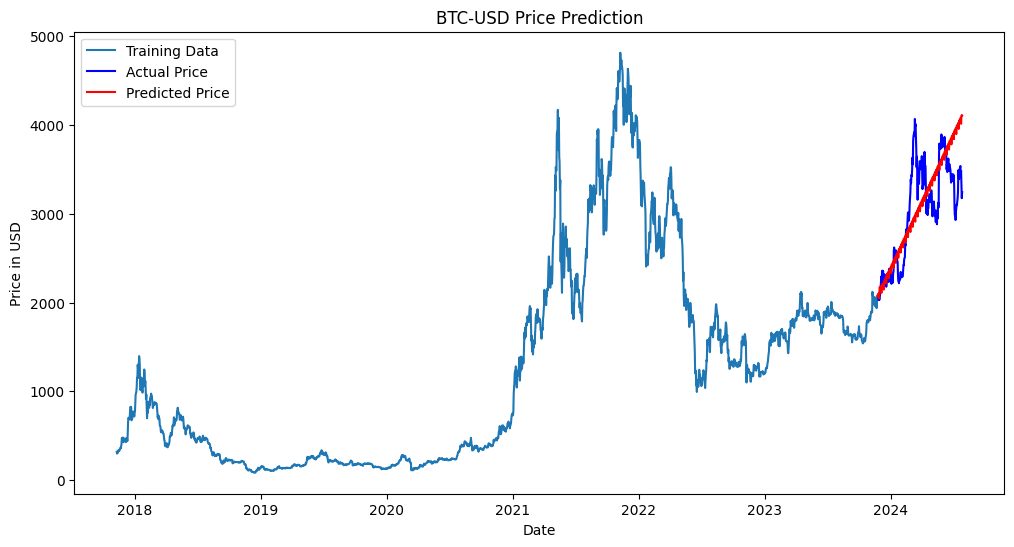

In [36]:
# Plot the forecast in original scale
plt.figure(figsize=(12,6))
plt.plot(data['Close'][:len(train_data)], label='Training Data')
plt.plot(actual_forecast.index, actual_forecast, color='blue', label='Actual Price')
plt.plot(fc_forecast.index, fc_forecast, color='red', label='Predicted Price')
plt.title('{series_name} Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend(loc='upper left')
plt.show()

In [37]:
# Evaluate model performance
mse = mean_squared_error(actual_forecast, fc_forecast)
mae = mean_absolute_error(actual_forecast, fc_forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_forecast - fc_forecast) / actual_forecast)) * 100

In [38]:
print('Mean Squared Error (MSE): {:.3f}'.format(mse))
print('Mean Absolute Error (MAE): {:.3f}'.format(mae))
print('Root Mean Squared Error (RMSE): {:.3f}'.format(rmse))
print('Mean Absolute Percentage Error (MAPE): {:.3f}%'.format(mape))

Mean Squared Error (MSE): 165316.403
Mean Absolute Error (MAE): 311.933
Root Mean Squared Error (RMSE): 406.591
Mean Absolute Percentage Error (MAPE): 9.886%


In [39]:
# Extend model to predict the next day's closing price
# Refit the model on the entire differenced data
full_model = SARIMAX(diff_data, order=order, seasonal_order=seasonal_order)
full_results = full_model.fit()

c:\Users\HomePC\Documents\finance_ml\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HomePC\Documents\finance_ml\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [40]:
# Forecast the next day's differenced value
next_day_diff_forecast = full_results.get_forecast(steps=1)
next_day_diff = next_day_diff_forecast.predicted_mean.iloc[0]

In [43]:
# Convert differenced forecast to original scale
last_close_value = data['Close'].iloc[-1]
next_day_forecast = last_close_value + next_day_diff

print(f"Next day's forecasted closing price: {next_day_forecast}")

if next_day_forecast > last_close_value:
    print("Buy")
else:
    print("Sell")

Next day's forecasted closing price: 3288.578467645514
Buy


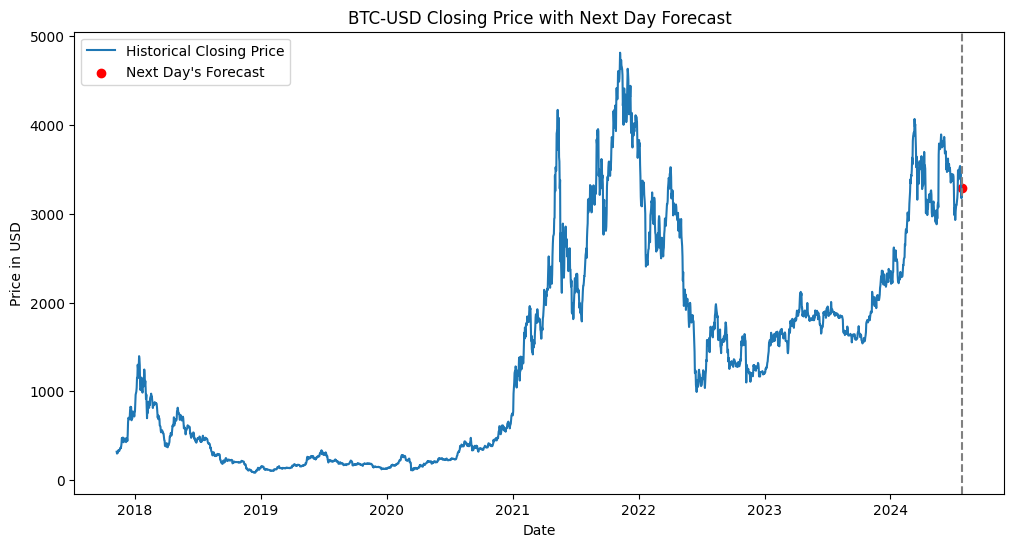

In [44]:
# Plot the forecast including the next day
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Historical Closing Price')
plt.axvline(x=data.index[-1], color='gray', linestyle='--')
plt.scatter(data.index[-1] + pd.Timedelta(days=1), next_day_forecast, color='red', label="Next Day's Forecast")
plt.title('{series_name} Closing Price with Next Day Forecast')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend(loc='upper left')
plt.show()

In [48]:
with open('arima_model.pkl', 'wb') as file:
    pk.dump(full_model, file)